grade: 5/5 great work!
# Homework 3 - Enticing Pronto Exploration

Janet Matsen

## Homework Goals: 
* create a guided, interactive notebook exploration of the Pronto data. 
* use the interact function (for plotting, etc.) 

Clear statement of the problem being investigated. (1 pt):

** Background **
Data for Seattle's Pronto bike share sytem have been made available.  These data include columms for:
* trip_id
* starttime
* stoptime
* bikeid
* tripduration
* from_station_name
* to_station_name
* from_station_id
* to_station_id
* usertype
* gender
* birthyear

We are tasked with exploring the data interactively.

**Objectives:** 
1. How many people are using the bikes longer than the expected 30 minute maximum?  How long are the longest trips?
2. What types of users keep bikes out "too long"?  
3. Where are they going? 


### Download the Pronto data

Use wget, as we did on class Monday 1/25. 

In [1]:
# import packages used herein
import ipywidgets 
from ipywidgets import interact
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wget
import zipfile

%matplotlib inline

In [2]:
print mpl.__version__
print 'installed a virtualenv ("seds") to be able to use 1.5, which resolved mysterious errors.'
# http://stackoverflow.com/questions/29842264/typeerror-histogram-got-an-unexpected-keyword-argument-new

1.5.1
installed a virtualenv ("seds") to be able to use 1.5, which resolved mysterious errors.


Using the download utils covered in Monday 1/27's lecture:

In [3]:
def download_pronto_data_if_needed():
    """
    Download pronto data if needed.  
    
    Detects whether the zip is downloaded, and downloads it to current dir if missing. 
    """
    if not os.path.exists('open_data_year_one.zip'):
        download_URL = 'https://s3.amazonaws.com/pronto-data/open_data_year_one.zip'
        wget.download(download_URL)
    print 'existing files:'
    !ls  # note: can print multiple files to one line. 
    
def get_pronto_data():
    """
    Fetch pronto data (if needed) and extract trips as dataframe
    """
    download_pronto_data_if_needed()
    zf = zipfile.ZipFile('open_data_year_one.zip')
    file_handle = zf.open('2015_trip_data.csv')
    return pd.read_csv(file_handle)

Use the download utilities above to get the pronto data. 

In [4]:
pronto_data = get_pronto_data()

existing files:
Homework 3 - Enticing Pronto Exploration.ipynb open_data_year_one
images                                         open_data_year_one.zip


Look at the columns in the data:

In [5]:
for col in pronto_data.columns:
    print col

trip_id
starttime
stoptime
bikeid
tripduration
from_station_name
to_station_name
from_station_id
to_station_id
usertype
gender
birthyear


Define some new handy columns.

In [6]:
# Define some new columns
pronto_data['trip minutes'] = pronto_data['tripduration']/60

## Questions 1, 2: Investigate the distribution of trip lengths & who the users are

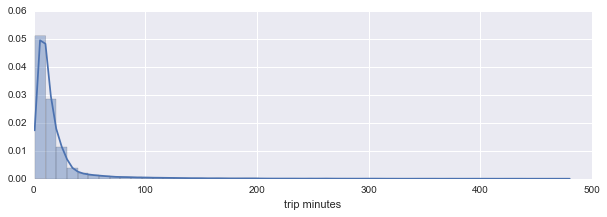

In [7]:
# First make a static plot to visualize the trip durations. 
sns.distplot(pronto_data['trip minutes'], norm_hist=False)

# make the figure wide:
fig = mpl.pyplot.gcf()
fig.set_size_inches(10, 3)

Are there really trips that take > 400 minutes?  
 
We can investigate this by restricting to times greater than a time specified by a slider. 
The y-axis will automatically change, allowing us to zoom in. 
I forced it to keep the same x-axis so it is clear we are looking at only a subset of x-values. 

In [8]:
pronto_data['trip hours'] = pronto_data['tripduration']/60/60

Define a function that allows for interactive plotting via the interact module:

-- Note that the both axes are changing as you zoom in! --


<function __main__.plot_distribution_of_ride_times>

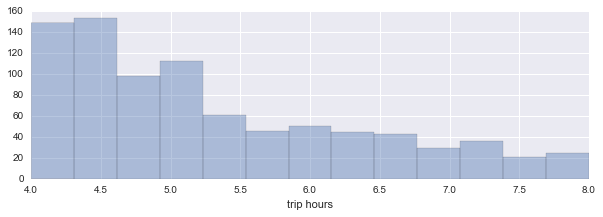

In [9]:
def plot_distribution_of_ride_times(trip_hours, usertype):
    '''
    Plot the pronto data  
    '''
    print "-- Note that the both axes are changing as you zoom in! --"
    # reduce data using slider
    plot_data = pronto_data[pronto_data['trip hours'] > trip_hours]
    
    # subset data based on user-type button. 
    if usertype == 'Annual Member':
        plot_data = plot_data[plot_data['usertype'] == 'Annual Member']
    if usertype == 'Short-Term Pass Holder':
        plot_data = plot_data[plot_data['usertype'] == 'Short-Term Pass Holder']
    if usertype == 'All':
        pass
    
    sns.distplot(plot_data['trip hours'], kde=False, norm_hist=False)
    # reduce 
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(10, 3)

interact(plot_distribution_of_ride_times, 
        trip_hours =(0,8), 
        usertype = ipywidgets.RadioButtons(description = 'user type', 
                                           options = ['All', 'Annual Member', 'Short-Term Pass Holder', ]))

We can see that there are more short-term users who get fees for long trips.  I was almost one of those people when I wanted to use Pronto to take my visiting friends on a cycling tour of Seattle!

By the way, how much do these long trips cost?!?

Look it up at the [Pronto Website](https://www.prontocycleshare.com/pricing): 

<img src="images/pronto_fees.png">

Let's assume the maxmum fee is $77, as this is the rate you pay for > 8 hours. 

In [10]:
def calculate_fee(minutes=0):
    """
    Use slider below to calculate the fee based on 
    the number of minutes you have the bike out. 
    """
    if minutes <= 30:
        print "Less than 30 minutes: FREE!"
    elif minutes <= 60:
        print "Fee = $2 for < 60 minutes"
    else: 
        fee = 2
        min_past_60 = minutes - 60
        fee += min_past_60/30*5
        if fee > 77:
            print 'Maximum fee ($77) reached!'
        else: 
            print 'Fee = ${} for {} minutes ({} hours)'.format(fee, minutes, minutes/60.)

interact(calculate_fee, minutes=(0, 700))

Less than 30 minutes: FREE!


<function __main__.calculate_fee>

## Questions 2, 3: Who takes the bikes out too long and where are they going? 

<function __main__.plot_trip_minutes_by_user>

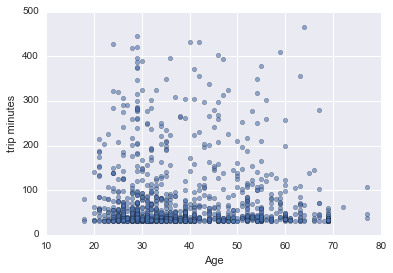

In [11]:
def plot_trip_minutes_by_user(gender, destination, alpha_value):
    plot_data = pronto_data
    
    # remove all the trips that didn't incur fines. 
    plot_data = plot_data[plot_data['trip minutes'] > 30]
    
    # Make a column for (approximate) age:
    #print plot_data.birthyear.unique()
    # df.dropna(subset = ['column1_name', 'column2_name', 'column3_name'])
    plot_data = plot_data.dropna(subset=['birthyear'])
    #print plot_data.birthyear.unique()
    plot_data['Age'] = 2016 - plot_data['birthyear'].astype('int')

    # subset data based on user-type button. 
    if gender == 'All':
        pass
    if gender == 'Female':
        plot_data = plot_data[plot_data['gender'] == 'Female']
    if gender == 'Male':
        plot_data = plot_data[plot_data['gender'] == 'Male']
    if gender == 'Other':
        plot_data = plot_data[plot_data['gender'] == 'Other']
    
    # Add another set of boxes to let you select popular tourist destinations.
    if destination == "All Destinations":
        pass
    if destination == 'Seattle Aquarium / Alaskan Way S & Elliott Bay Trail':
        plot_data = plot_data[plot_data['to_station_name'] == 'Seattle Aquarium / Alaskan Way S & Elliott Bay Trail']
    if destination == 'Lake Union Park / Valley St & Boren Ave N':
        plot_data = plot_data[plot_data['to_station_name'] == 'Lake Union Park / Valley St & Boren Ave N']
    if destination == 'Key Arena / 1st Ave N & Harrison St':
        plot_data = plot_data[plot_data['to_station_name'] == 'Key Arena / 1st Ave N & Harrison St']
    
    return plot_data.plot.scatter(x='Age', y='trip minutes', alpha=alpha_value)
    
# plot_trip_minutes_by_user()

interact(plot_trip_minutes_by_user, 
         alpha_value = (.2, 1.),
         gender = ipywidgets.RadioButtons(description = 'gender', 
                                           options = ['All', 'Male', 'Female', 'Other' ]),
         destination = ipywidgets.RadioButtons(description = 'destination', 
                                           options = ["All Destinations",
                                                      'Seattle Aquarium / Alaskan Way S & Elliott Bay Trail',
                                                     'Lake Union Park / Valley St & Boren Ave N',
                                                      'Key Arena / 1st Ave N & Harrison St'
                                                     ]))

## Summary of Findings:
* many people have the bikes out longer than the period that is free (30 minues).  Most of these are day-pass users.  Perhaps they wanted to take a tour of the city and didn't know that was not an intended use case.
* Many of the trips last 8 hours, thereby reaching the maximum $77 late fine. 
* Many of the users like to go to popular tourist destinations.  There are not clear trends for who goes where by rider age in the subset of destinations I investigated. 


## Use of notebook commands, magic commands, shell commands, and other material 

Some of my new favorite iPython notebook tricks are: 
* Tab completion of variable and function names.
* Converting a cell to markdown (Ctrl-m m)  (perhaps most used shortcut!)
* Inserting a new cell above: (Ctrl-m a)
* Inserting a new cell above: (Ctrl-m b)
* Shell commands from the notebook: I checked the status of my file downloads using the ! to escape a shell command.  E.g.: `! ls`
* Ctrl-m dd to delete cells
* Ctrl-m a to go to the first position in a cell, Ctrl-m e to go to the last. 

I have also picked up things we didn't discuss in lecture.  These include: 
* Formatting the ls command above using back-ticks
* Adding the Pronto URL above. 
* Inserting an image into a markdown cell. 
* Find and replace all from the Edit menu: shows all proposed changes in one colorful view. 
* Select multiple cells and move them with the arrows. 
* Shift tab tab: opens information about arguments for the function you are writing argument for. 